# Deep Learning with multiple GPUs
CIFAR-10 dataset will be used to train a deep learning model using Multiple GPUs. The current model is trained on Texas Advanced Computing Center's Frontera HPC. The current training is run on a single node with 4 Nvidia Quadro RTX 5000 GPUs.

<img src="nvidiasmi_tacc.jpg" width="600">

Horovod (https://horovod.ai/), a deep learning framework for TensorFlow will be used to scale training to multiple GPUs. Since this is run using existing MPI (i.e. requiring mpirun), the output from training is parsed to this notebook.

## Dataset
CIFAR-10 dataset is a collection of 60,000 color images of 32 x 32 pixel in 10 different classes. The 10 classes represent airplanes, cars, birds, cats, deer, dogs, frogs, horses, ships, and trucks. The dataset has 6000 images of each class.

In [ ]:
# Import libraries
import os
import numpy as np
from time import time
import tensorflow as tf

from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing import image
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.callbacks import Callback, LearningRateScheduler
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Dense, Add, Activation, Dropout, MaxPooling2D, GlobalAveragePooling2D

import horovod.tensorflow.keras as hvd
from hvd.callbacks import LearningRateWarmupCallback, BroadcastGlobalVariablesCallback, MetricAverageCallback

### Horovod - processing on multi GPUs
Initialize Horovod and pin it to a GPU.

In [ ]:
# Initialize horovod
hvd.init()

# Pin to a GPU
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    tf.config.set_memory_growth(gpus[hvd.local_rank()], True)
    tf.config.set_visible_devices(gpus[hvd.local_rank()], 'GPU')

print(gpus)

### Parameters

In [ ]:
#%% Parameters
batch_size = 128
epochs     = 50

warmup_epochs = 5    # No of epochs for which base learning rate will be used
momentum = 0.9       # Momentum for Stochastic Gradient Descent

base_learning_rate = 0.01 # Learning rate for 1 GPU

train_target = 0.8 # Training target accuracy
val_target   = 0.8 # Validation target accuracy

# Set verbose based on GPU rank
if hvd.rank() == 0:
    verbose = 1
else:
    verbose = 0 # prints total time

### Load CIFAR-10 dataset

In [ ]:
# Load data
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Input image dimensions
img_rows, img_cols = 32, 32

# Reformat to Keras friendly format
if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 3, img_rows, img_cols)
    x_test  = x_test.reshape(x_test.shape[0], 3, img_rows, img_cols)
    input_shape = (3, img_rows, img_cols)
    
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 3)
    x_test  = x_test.reshape(x_test.shape[0], img_rows, img_cols, 3)
    input_shape = (img_rows, img_cols, 3)


# Convert classes to categorical values
y_train = tf.keras.utils.to_categorical(y_train, 10)
y_test  = tf.keras.utils.to_categorical(y_test, 10)

# Convert train / test to float
x_train = x_train.astype('float32')
x_test  = x_test.astype('float32')

# Scale data to 0 - 1
x_train /= 255
x_test  /= 255

### Training Dataset Generator

In [ ]:
# Image Data Generator
# This will be used to perform additional processing on the images that
# will help with training
datagen = image.ImageDataGenerator(
            featurewise_center=False,            # set input mean to 0 over the dataset
            samplewise_center=False,             # set each sample mean to 0
            featurewise_std_normalization=False, # divide inputs by std of the dataset
            samplewise_std_normalization=False,  # divide each input by its std
            zca_whitening=False,                 # apply ZCA whitening
            zca_epsilon=1e-06,                   # epsilon for ZCA whitening
            rotation_range=0,                    # randomly rotate images in the range (degrees, 0 to 180)
            width_shift_range=0.1,               # randomly shift images horizontally (fraction of total width)
            height_shift_range=0.1,              # randomly shift images vertically (fraction of total height)
            shear_range=0.,                      # set range for random shear
            zoom_range=0.,                       # set range for random zoom
            channel_shift_range=0.,              # set range for random channel shifts
            fill_mode='nearest',                 # set mode for filling points outside the input boundaries
            cval=0.,                             # value used for fill_mode = "constant"
            horizontal_flip=True,                # randomly flip images
            vertical_flip=False,                 # randomly flip images
            rescale=None,                        # set rescaling factor (applied before any other transformation)
            preprocessing_function=None,         # set function that will be applied on each input
            data_format=None,                    # image data format, either "channels_first" or "channels_last"
            validation_split=0.0)                # fraction of images reserved for validation (strictly between 0 and 1)

# Compute quantities required for feature-wise normalization
# (std, mean, and principal components if ZCA whitening is applied).
datagen.fit(x_train)

# Create training iterator
train_iter = datagen.flow(x_train, y_train, batch_size=batch_size)

### Test dataset generator

In [ ]:
# Datagenerator for Test dataset
test_datagen = image.ImageDataGenerator(featurewise_center=True,
                                        featurewise_std_normalization=True)

test_datagen.mean = datagen.mean
test_datagen.std  = datagen.std

# Test iterator
test_iter = test_datagen.flow(x_test, y_test, batch_size=batch_size)

## Modeling
A deep learning model is built based on the WideResNet model with depth of 16 and width of 10. The model is built with the functional API of Keras. Since the model will be run on 4 GPUs, these cells will be used in a separate python script and run with mpirun.

The WideResNet implementation is based on https://github.com/keras-team/keras-contrib/blob/master/keras_contrib/applications/wide_resnet.py

In [2]:
# Create model
def create_model(input_shape, baselr, momentum):
    
    # Helper functions - convolution with Batch Normalization
    def conv_batchnorm(x, conv_size, channel_axis):
        
        x = Conv2D(filters=conv_size, kernel_size=(3,3), padding='same')(x)
        x = BatchNormalization(axis=channel_axis)(x)
        x = Activation('relu')(x)
        
        return x

    # Convolution block - calls conv_batchnorm and adds drop out
    def conv_block(x, conv_size, channel_axis, scale_input = False):
        x_0 = x
        if scale_input:
            x_0 = Conv2D(conv_size, (1, 1), activation='linear', padding='same')(x_0)

        x = conv_batchnorm(x, conv_size, channel_axis)
        x = Dropout(0.01)(x)
        x = conv_batchnorm(x, conv_size, channel_axis)
        x = Add()([x_0, x])

        return x
    
    # Input
    inputs = Input(shape=input_shape) # 32 x 32 RGB
    
    # Channel axis
    channel_axis = 1 if K.image_data_format() == 'channels_first' else -1
    
    # Model - 1st layer
    x = conv_batchnorm(inputs, 16, channel_axis)
    
    # 1st conv block with and without scaling
    x = conv_block(x, 160, channel_axis, True)
    x = conv_block(x, 160, channel_axis)
    x = MaxPooling2D((2, 2))(x)
    
    # 2nd conv block
    x = conv_block(x, 320, channel_axis, True)
    x = conv_block(x, 320, channel_axis)
    x = MaxPooling2D((2, 2))(x)
    
    # 3rd conv block
    x = conv_block(x, 640, channel_axis, True)
    x = conv_block(x, 640, channel_axis)
    x = GlobalAveragePooling2D()(x)
  
    # Output dense layer of 10 classes with softmax activation
    outputs = Dense(10, activation='softmax')(x)

    model = Model(inputs, outputs)

    opt = SGD(lr=baselr, momentum=momentum)

    # Wrap optimizer in Horovod distributed optimizer
    opt = hvd.DistributedOptimizer(opt)
    
    # Compile
    model.compile(loss=categorical_crossentropy,
                  optimizer=opt,
                  metrics=['accuracy'])
    
    return model

### Callbacks - helper functions to control training

In [ ]:
# Callbacks for printing total time and for early stopping
# For early stopping, train and validation targets are used
# For the first run, training will be run for all epochs
# and for the subsequent run, training will be stopped at a
# set value of validation and training target accuracy

# Total time
class PrintTotalTime(Callback):
    def on_train_begin(self, logs=None):
        self.start_time = time()
    
    def on_epoch_end(self, epoch, logs=None):
        elapsed_time = round(time() - self.start_time, 2)
        print("Elapsed training time through epoch {}: {}".format(epoch+1, elapsed_time))

    def on_train_end(self, logs=None):
        total_time = round(time() - self.start_time, 2)
        print("Total training time: {}".format(total_time)) 

class PrintThroughput(Callback):
    def __init__(self, total_images=0):
        self.total_images = total_images

    def on_epoch_begin(self, epoch, logs=None):
        self.epoch_start_time = time()

    def on_epoch_end(self, epoch, logs={}):
        epoch_time = time() - self.epoch_start_time
        images_per_sec = round(self.total_images / epoch_time, 2)
        print('Images/sec: {}'.format(images_per_sec))

# Stop accuracy
class StopAtAccuracy(Callback):
    def __init__(self, train_target=0.75, val_target=0.25, patience=2, verbose=0):
        self.train_target = train_target
        self.val_target = val_target
        self.patience = patience
        self.verbose = verbose
        self.stopped_epoch = 0
        self.met_train_target = 0
        self.met_val_target = 0

    def on_epoch_end(self, epoch, logs=None):
        if logs.get('accuracy') > self.train_target:
            self.met_train_target += 1
        else:
            self.met_train_target = 0
            
        if logs.get('val_accuracy') > self.val_target:
            self.met_val_target += 1
        else:
            self.met_val_target = 0

        if self.met_train_target >= self.patience and self.met_val_target >= self.patience:
            self.stopped_epoch = epoch
            self.model.stop_training = True

    def on_train_end(self, logs=None):
        if self.stopped_epoch > 0 and verbose == 1:
            print('Early stopping after epoch {}. Training accuracy target ({}) and validation accuracy target ({}) met.'.format(self.stopped_epoch + 1, self.train_target, self.val_target))

# Save training data
class SaveTrainingData(Callback):
    def __init__(self, data_filepath=''):
        self.data_filepath = data_filepath

    def on_train_begin(self, logs=None):       
        file = open(self.data_filepath, 'w', newline='')
        writer = csv.writer(file)
        writer.writerow(['time', 'val_accuracy'])
        writer.writerow([0.0, 0.0])
        file.close()  

        self.train_start_time = time()

    def on_epoch_end(self, epoch, logs={}):
        total_time = time() - self.train_start_time
        file = open(self.data_filepath, 'a')
        writer = csv.writer(file)
        writer.writerow([round(total_time,1), round(logs['val_accuracy'], 4)])
        file.close()

# Learning rate scheduler
# Base learning rate is set in parameters
# based on the number of epochs, the learning
# rate will be changed. Initial epochs will use
# base learning rate which will be exponentially
# reduced for further epochs
def lr_schedule(epoch):
    if epoch < 15:
        return base_learning_rate
    if epoch < 25:
        return 1e-1 * base_learning_rate
    if epoch < 35:
        return 1e-2 * base_learning_rate
    return 1e-3 * base_learning_rate

### Model 1 - with early stop callback

In [ ]:
# Callbacks
callbacks = [LearningRateScheduler(lr_schedule), 
             LearningRateWarmupCallback(initial_lr=base_learning_rate,
                                        warmup_epochs=warmup_epochs,
                                        verbose=verbose),
             BroadcastGlobalVariablesCallback(0),
             MetricAverageCallback(),
             PrintThroughput(total_images=len(y_train)),
             StopAtAccuracy(train_target=train_target, val_target=val_target, verbose=verbose)]

# Append total time and save training data on local node
if verbose:
    callbacks.append(PrintTotalTime())

    data_filepath = "{}ranks-{}bs-{}lr-{}m-{}w-stop.csv".format(hvd.size(), batch_size, base_learning_rate, momentum, warmup_epochs)

    callbacks.append(SaveTrainingData(data_filepath=data_filepath))

In [ ]:
# Create model
model = create_model(input_shape, base_learning_rate, momentum)
model.summary()

# Fit the model on the batches generated by datagen
model.fit(train_iter,
          callbacks=callbacks,
          epochs=epochs,
          verbose=verbose,
          initial_epoch=0,
          steps_per_epoch=len(train_iter) // hvd.size(),
          validation_data=test_iter,
          validation_steps=3 * len(test_iter) // hvd.size(),
          workers=4)

# Score trained model.
scores = model.evaluate(test_iter,
                        steps=len(test_iter),
                        workers=4,
                        verbose=verbose)

if verbose:
    print('Test loss:', scores[0])
    print('Test accuracy:', scores[1])

### Model 2 - run all epochs

In [ ]:
# Callbacks
callbacks = [LearningRateScheduler(lr_schedule), 
             LearningRateWarmupCallback(initial_lr=base_learning_rate,
                                        warmup_epochs=warmup_epochs,
                                        verbose=verbose),
             BroadcastGlobalVariablesCallback(0),
             MetricAverageCallback(),
             PrintThroughput(total_images=len(y_train))]

# Append total time and save training data on local node
if verbose:
    callbacks.append(PrintTotalTime())

    data_filepath = "{}ranks-{}bs-{}lr-{}m-{}w.csv".format(hvd.size(), batch_size, base_learning_rate, momentum, warmup_epochs)

    callbacks.append(SaveTrainingData(data_filepath=data_filepath))

In [ ]:
# Create model
model = create_model(input_shape, base_learning_rate, momentum)
model.summary()

# Fit the model on the batches generated by datagen
model.fit(train_iter,
          callbacks=callbacks,
          epochs=epochs,
          verbose=verbose,
          initial_epoch=0,
          steps_per_epoch=len(train_iter) // hvd.size(),
          validation_data=test_iter,
          validation_steps=3 * len(test_iter) // hvd.size(),
          workers=4)

# Score trained model.
# Score trained model.
scores = model.evaluate(test_iter,
                        steps=len(test_iter),
                        workers=4,
                        verbose=verbose)
if verbose:
    print('Test loss:', scores[0])bbb
    print('Test accuracy:', scores[1])

## Summary
The above code is saved in a python file which is available at:
<br>[multi_gpu](https://github.com/drsaikirant88/drsaikirant88.github.io/blob/main/IBM%20Machine%20Learning/classification_multigpu.py)

A single GPU version of the code following similar code structure is available at:
<br>[single_gpu](https://github.com/drsaikirant88/drsaikirant88.github.io/blob/main/IBM%20Machine%20Learning/classification_singlegpu.py)

The code was executed by running:
<br>$ mpirun -np 4 python classification_multigpu.py

The training and validation accuracy target was set at 0.8. The stop at accuracy callback ensures that the model is able to achieve the target accuracy for two consequent epochs. Although the model crossed the training accuracy target after 8 epochs, the validation accuracy was achieved only after 16 epochs. The model was reinitialized and run for 50 epochs and showed similar performance. The test validation accuracy did not change significantly after 18 epochs and the maximum validation accuracy achieved was 0.87 using a batch size of 128, and a base learning rate of 0.01

In [1]:
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt

[Text(0.5, 1.0, 'Validation accuracy all epochs')]

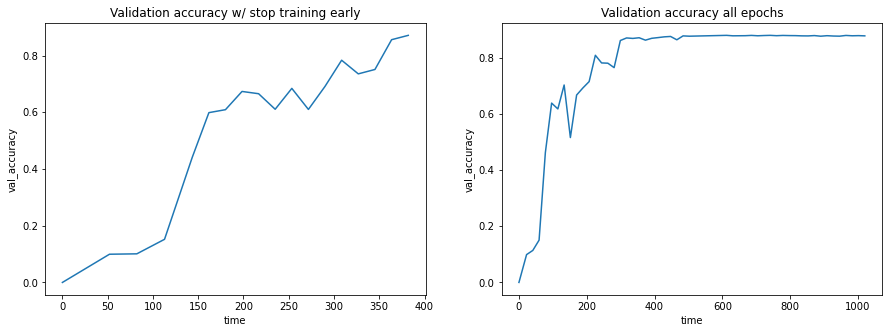

In [4]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15, 5))
sns.lineplot(data=model1_output, x='time', y='val_accuracy', ax=ax1)
ax1.set(title='Validation accuracy w/ stop training early')
sns.lineplot(data=model2_output, x='time', y='val_accuracy', ax=ax2)
ax2.set(title='Validation accuracy all epochs')